In [1]:
from utils_az import FishEyeImage, rot
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from scipy.optimize import minimize, curve_fit
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, angular_separation, position_angle, offset_by, ICRS


2024-06-03 22:09:45,387:tetra3.Tetra3-INFO: Loading database from: /Users/mlang/miniconda3/lib/python3.11/site-packages/tetra3/data/default_database.npz


In [2]:
file = '291A2094'

zhangbei = EarthLocation(lon=115*u.deg+14*u.arcsec,lat=41*u.deg+13*u.arcmin+53*u.arcsec,height = 1466)
dunhuang  = EarthLocation(lon=94.322799*u.deg,lat=40.359581*u.deg,height = 1100)
pic = FishEyeImage( file+'.CR3',loc = zhangbei)

solution = pic.solve(solve_size=1000)

{'RA': 136.1071354526942, 'Dec': -19.576161110403675, 'Roll': 13.077126103819579, 'FOV': 23.67274791947131, 'distortion': -0.005733788533011405, 'RMSE': 32.157171833240966, 'Matches': 24, 'Prob': 1.1101057573626384e-42, 'epoch_equinox': 2000, 'epoch_proper_motion': 2023.0, 'T_solve': 4.90404199808836, 'T_extract': 24.921415955759585}


In [3]:
pic.first_match(bin_size=5000)

(array([1247,    0,    0, ..., 1247,    2, 1332]),
 <Angle [49.18002368, 62.36303594, 57.8926898 , ..., 52.90702658,
         55.93312791, 49.14284011] deg>)

[ 2.81298622  0.47001904 -0.03376914 14.5997729  -0.20502334]
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 13.894246107234746
        x: [ 2.813e+00  4.700e-01 -3.377e-02  1.460e+01 -2.050e-01]
      nit: 1
      jac: [ 1.084e-05 -3.908e-06 -8.882e-07 -1.563e-05  9.059e-06]
     nfev: 18
     njev: 3
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


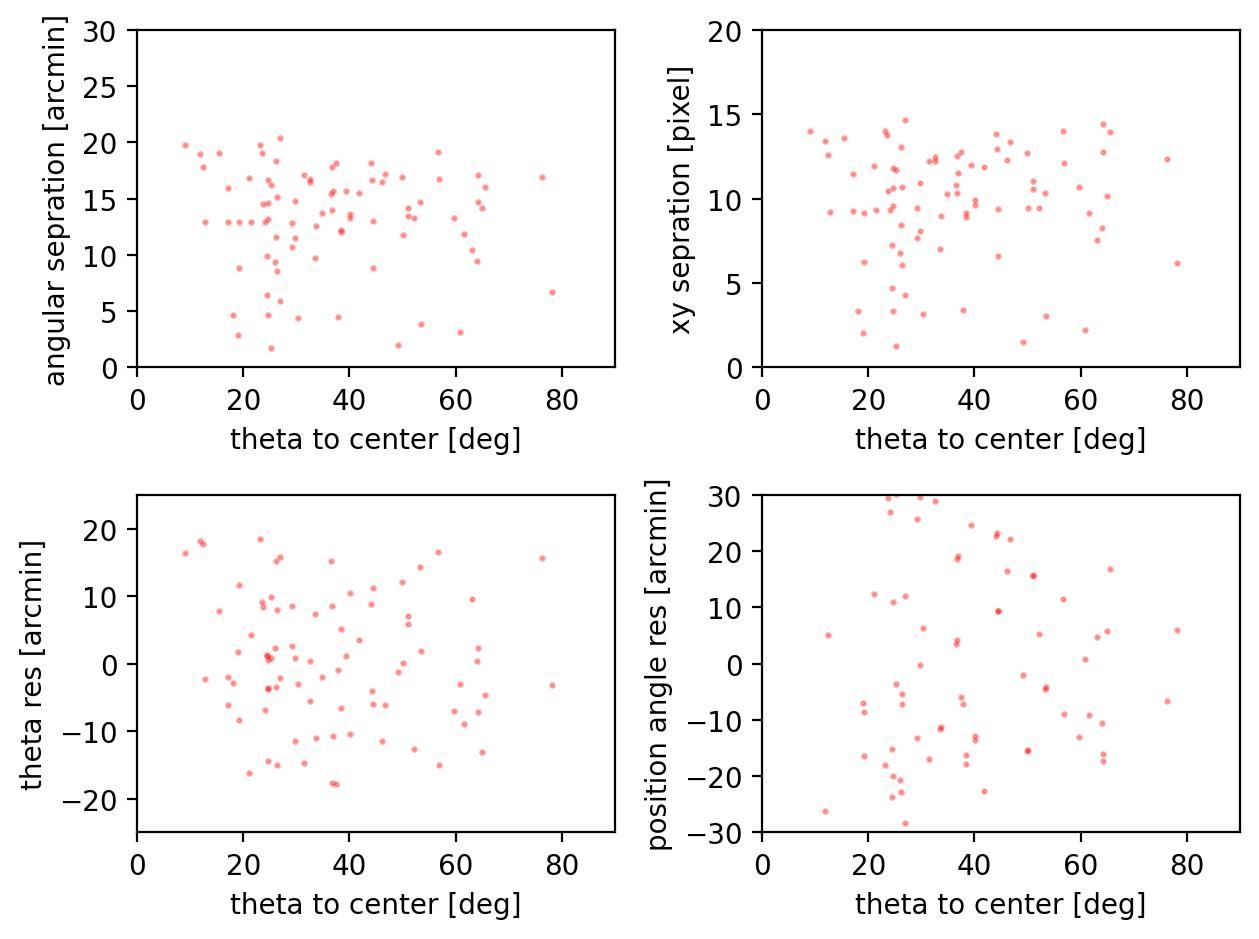

In [6]:
init , final = pic.lens_optimize(az_alt_range=8, roll_range=180,f_range=2,k_range=0.2)
print(init)
print(final)
x = final.x
pic.az=x[0]
pic.alt = x[1]
pic.az_roll = x[2]
pic.f=x[3]
pic.k=x[4]
pic.draw_residual(dpi=200, s=2, c = 'red',alpha=0.3)

In [4]:
init , final = pic.plate_optimize(ra_dec_range=8, roll_range=8,c_xy_range=150)
print(final)
x= final.x
pic.ra=x[0]
pic.dec = x[1]
pic.roll = x[2]
pic.c_x =x[3]
pic.c_y =x[4]
pic.draw_residual(dpi=200, s=2, c = 'red',alpha=0.3)

AttributeError: 'FishEyeImage' object has no attribute 'ra'

In [ ]:
catalog_x, catalog_y, catalog_theta, catalog_pa = pic.eq_to_xy(
            pic.ra*u.rad, pic.dec*u.rad, pic.matched_catalog_skycoords.ra, pic.matched_catalog_skycoords.dec)

(array([27., 65., 40., 37., 43., 40., 44., 38., 41., 18.]),
 array([ 2.44567765, 10.02643269, 17.60718773, 25.18794278, 32.76869782,
        40.34945286, 47.9302079 , 55.51096295, 63.09171799, 70.67247303,
        78.25322807]),
 <BarContainer object of 10 artists>)

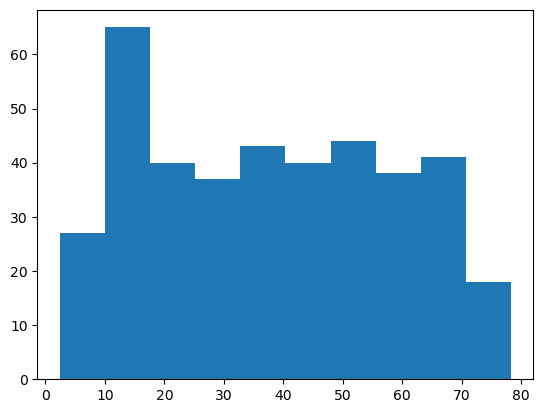

In [ ]:
plt.hist(catalog_theta.to(u.deg))

(0.0, 23.0)

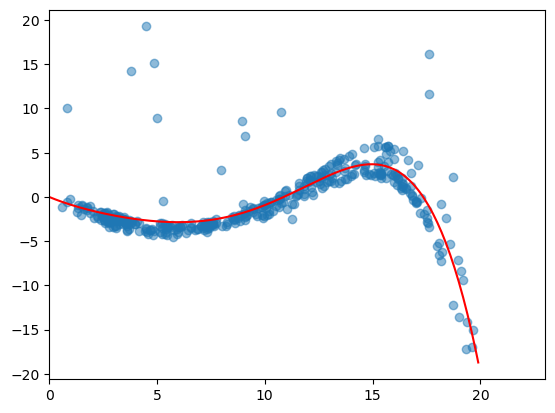

In [ ]:
x  = pic.matched_stars_xy['xcentroid']
y =  pic.matched_stars_xy['ycentroid']
stars_ra, stars_dec, matched_stars_theta, matched_stars_pa = pic.xy_to_eq(
            pic.matched_stars_xy['xcentroid'], pic.matched_stars_xy['ycentroid'], c_ra=pic.ra, c_dec=pic.dec, roll=pic.roll, f=pic.f, k=pic.k,c_x=pic.c_x,c_y=pic.c_y)
delta_x = x - pic.c_x
delta_y = y - pic.c_y
delta_xy = np.asarray([delta_x, delta_y])
delta_xy = np.dot([[1, 0], [0, -1]], delta_xy)
# delta_xy = rot(delta_xy, -roll-np.pi/2)
r = np.sqrt(delta_x**2+delta_y**2)*pic.pixel_size
plt.scatter(r,matched_stars_theta-catalog_theta,alpha=0.5)

def func(r, a,b,c,d,e):
    return a*r**5+b*r**4+c*r**3+d*r**2+e*r

[a,b,c,d,e],_ = curve_fit(func,r,matched_stars_theta-catalog_theta)
rs  =np.arange(0,20,0.1)
plt.plot(rs,func(rs,a,b,c,d,e),c='red')
ax=plt.gca()
ax.set_xlim(0,23)

(-4.0, 4.0)

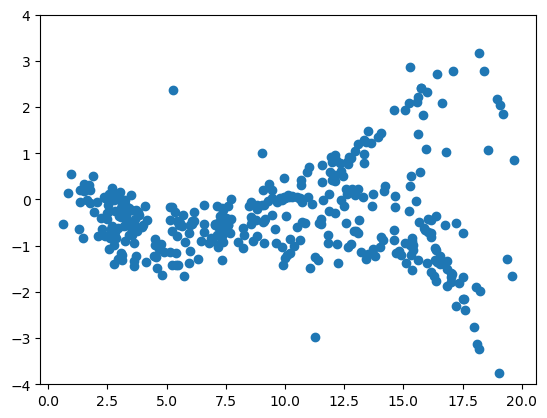

In [ ]:
plt.scatter(r,(matched_stars_theta-catalog_theta)-func(r,a,b,c,d,e)*u.arcmin)
ax=plt.gca()
ax.set_ylim(-4,4)

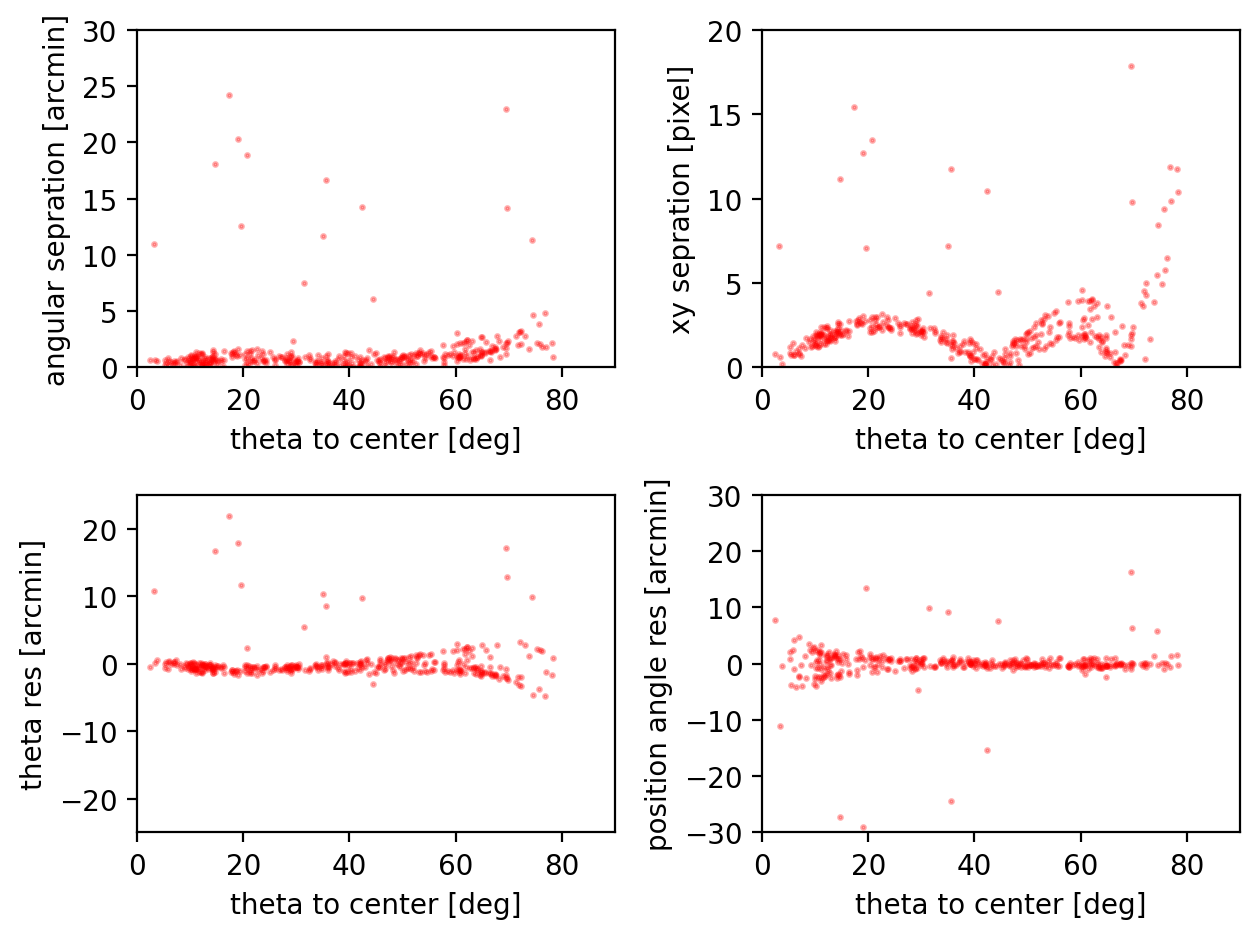

In [ ]:
pic.distort_optimize()
pic.draw_residual_dis(dpi=200, s=2, c = 'red',alpha=0.3)